In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/mtcnn/'

/content/gdrive/My Drive/mtcnn


In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 12.0MB/s 


In [ ]:
import mtcnn
print(mtcnn.__version__)

0.1.0


Using TensorFlow backend.


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
filename = "download.jpg"

In [ ]:
pixels = plt.imread(filename)
print("Shape of image/array = ",pixels.shape)

Shape of image/array =  (207, 243, 3)


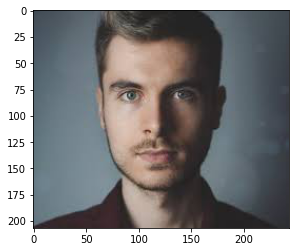

In [ ]:
imgplot = plt.imshow(pixels)
plt.show()

In [ ]:
detector = mtcnn.MTCNN()
faces = detector.detect_faces(pixels)
for face in faces:
  print(face)

{'box': [64, 22, 106, 142], 'confidence': 0.9996788501739502, 'keypoints': {'left_eye': (91, 81), 'right_eye': (141, 80), 'nose': (115, 111), 'mouth_left': (97, 135), 'mouth_right': (137, 134)}}


In [ ]:
def draw_facebox(filename,result_list):
  data = plt.imread(filename)
  plt.imshow(data)
  ax = plt.gca()
  for result in result_list:
    x, y, w, h = result['box']
    rect = plt.Rectangle((x,y),w,h,fill = False,color = 'blue')
    ax.add_patch(rect)
    plt.show()

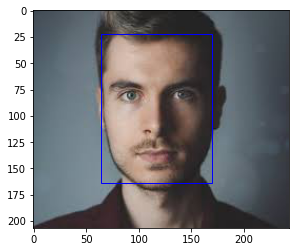

In [ ]:
faces = detector.detect_faces(pixels)
draw_facebox(filename,faces)

In [ ]:
def draw_facebox_details(filename,result_list):
  data = plt.imread(filename)
  plt.imshow(data)
  ax = plt.gca()
  for result in result_list:
    x, y, w, h = result['box']
    rect = plt.Rectangle((x,y),w,h,fill = False,color = 'blue')
    ax.add_patch(rect)
    for key,value in result['keypoints'].items():
      dot = plt.Circle(value,radius=10,color='pink')
      ax.add_patch(dot)
    plt.show()

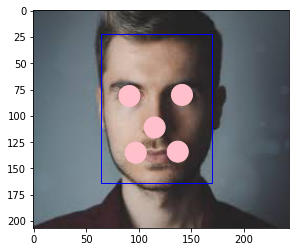

In [ ]:
faces = detector.detect_faces(pixels)
draw_facebox_details(filename,faces)

In [ ]:
!pip install facenet-pytorch 
!conda install -c anaconda keras-gpu

     |████████████████████████████████| 1.9MB 10.7MB/s 
/bin/bash: conda: command not found


In [ ]:
from facenet_pytorch import MTCNN
from PIL import Image
import torch
from imutils.video import FileVideoStream
import cv2
import time
import glob
from tqdm.notebook import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

filenames = ["download.jpg","download1.jpeg"]

In [ ]:
class FastMTCNN(object):
  """Fast MTCNN implementation."""
  def __init__(self, stride, resize=1, *args, **kwargs):
    """Constructor for FastMTCNN class.
        
        Arguments:
            stride (int): The detection stride. Faces will be detected every `stride` frames
                and remembered for `stride-1` frames.
        
        Keyword arguments:
            resize (float): Fractional frame scaling. [default: {1}]
            *args: Arguments to pass to the MTCNN constructor. See help(MTCNN).
            **kwargs: Keyword arguments to pass to the MTCNN constructor. See help(MTCNN).
    """
    self.stride = stride
    self.resize = resize
    self.mtcnn = MTCNN(*args, **kwargs)
        
  def __call__(self, frames):
    """Detect faces in frames using strided MTCNN."""
    if self.resize != 1:
      frames = [
                cv2.resize(f, (int(f.shape[1] * self.resize), int(f.shape[0] * self.resize)))
                    for f in frames
            ]
                      
      boxes, probs = self.mtcnn.detect(frames[::self.stride])

      faces = []
      for i, frame in enumerate(frames):
        box_ind = int(i / self.stride)
        if boxes[box_ind] is None:
          continue
          for box in boxes[box_ind]:
            box = [int(b) for b in box]
            faces.append(frame[box[1]:box[3], box[0]:box[2]])
        
      return faces

In [ ]:
# define our extractor
fast_mtcnn = FastMTCNN(
    stride=4,
    resize=0.5,
    margin=14,
    factor=0.6,
    keep_all=True,
    device=device
)

In [ ]:
def run_detection(fast_mtcnn, filenames):
    frames = []
    frames_processed = 0
    faces_detected = 0
    batch_size = 60
    start = time.time()

    for filename in tqdm(filenames):

        v_cap = FileVideoStream(filename).start()
        v_len = int(v_cap.stream.get(cv2.CAP_PROP_FRAME_COUNT))

        for j in range(v_len):

            frame = v_cap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

            if len(frames) >= batch_size or j == v_len - 1:

                faces = fast_mtcnn(frames)

                frames_processed += len(frames)
                faces_detected += len(faces)
                frames = []

                print(
                    f'Frames per second: {frames_processed / (time.time() - start):.3f},',
                    f'faces detected: {faces_detected}\r',
                    end=''
                )

        v_cap.stop()

run_detection(fast_mtcnn, filenames)

Frames per second: 0.925, faces detected: 0
